# DDSP experiments

To run notebook you need to use older version of Python. We used this version:
* Python 3.7.17

You also need to install these versions of libraries:
* crepe==0.0.12
* ddsp==3.7.0
* gin-config==0.5.0
* ipykernel==5.5.5
* jupyter==1.1.1
* jupyter-console==5.2.0
* librosa==0.10.0
* matplotlib==3.5.3
* tensorflow==2.11.0

This code loads DDSO model to process audio. To do this, you need to have pretrained model downloaded to `/notebook/pretrained_model`.

In [12]:
import ddsp
from ddsp.training import models
from ddsp.training.postprocessing import detect_notes, fit_quantile_transform
from ddsp.training import metrics
import gin
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
audio_name = 'brahms'  # Replace with your file path
audio, sr = librosa.load(librosa.example(audio_name, hq=True), sr=16000, mono=True)
audio = audio[np.newaxis, :]  # Add batch dimension
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].numpy().astype(np.float32)
print(f"Loaded audio with shape: {audio.shape}")
print(f"Loudness shape: {audio_features['loudness_db'].shape}")

/home/szymon_pc/STUDIA/WIMU/EchoMark/ddsp_venv/lib/python3.7/site-packages/librosa/core/convert.py:1896: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/home/szymon_pc/STUDIA/WIMU/EchoMark/ddsp_venv/lib/python3.7/site-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]


Loaded audio with shape: (1, 733519)
Loudness shape: (11462,)


In [14]:
import os

model_dir = 'pretrained_model'  # e.g., 'solo_violin_ckpt'
gin_file = os.path.join(model_dir, 'operative_config-0.gin')
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)
time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',
]
with gin.unlock_config():
  gin.parse_config(gin_params)

for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]

model = models.Autoencoder()
model.restore(ckpt)
_ = model(audio_features, training=False)  # Build model
print('Model loaded.')

/home/szymon_pc/STUDIA/WIMU/EchoMark/ddsp_venv/lib/python3.7/site-packages/librosa/core/convert.py:1896: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


Model loaded.


In [15]:
outputs = model(audio_features, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio_gen = audio_gen.numpy()[0]
print('Processed audio generated.')

/home/szymon_pc/STUDIA/WIMU/EchoMark/ddsp_venv/lib/python3.7/site-packages/librosa/core/convert.py:1896: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


Processed audio generated.


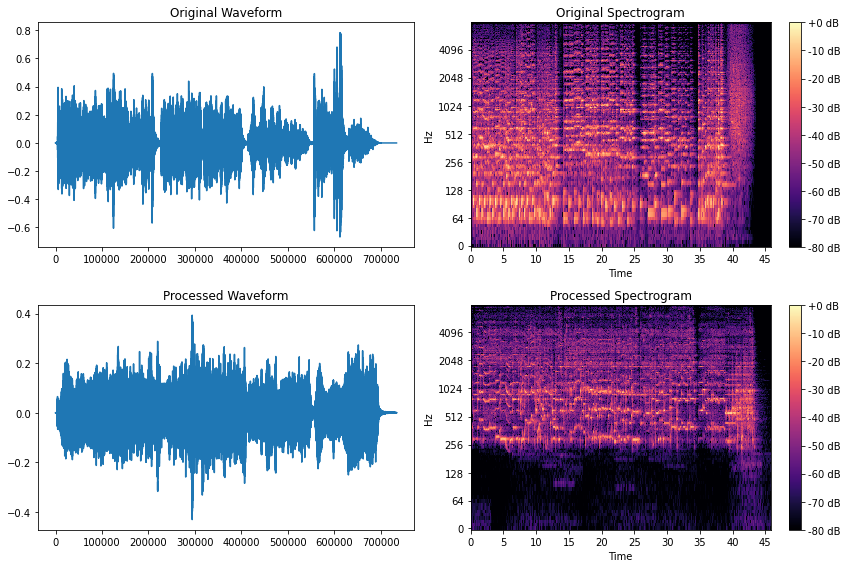

In [16]:
original_audio = audio[0]
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Original Waveform')
plt.plot(original_audio)
plt.subplot(2, 2, 2)
plt.title('Original Spectrogram')
spec = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio)), ref=np.max)
librosa.display.specshow(spec, sr=16000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 2, 3)
plt.title('Processed Waveform')
plt.plot(audio_gen)
plt.subplot(2, 2, 4)
plt.title('Processed Spectrogram')
spec_gen = librosa.amplitude_to_db(np.abs(librosa.stft(audio_gen)), ref=np.max)
librosa.display.specshow(spec_gen, sr=16000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [17]:
import soundfile as sf

# Optional: Normalize to [-1, 1] if needed (DDSP outputs are usually scaled)
audio_gen_normalized = audio_gen / np.max(np.abs(audio_gen)) if np.max(np.abs(audio_gen)) > 1 else audio_gen

sf.write('processed_audio.wav', audio_gen_normalized, 16000)
print("Processed audio saved as 'processed_audio.wav'")

Processed audio saved as 'processed_audio.wav'
